In [60]:
import yfinance as yf
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)

# TODO: Calcular quantidade de acoes de cad alado (beta)
# TODO: Definir janela de tempo dos dados


In [61]:
# Parameters
LST_B3_STOCKS = ["ABEV3","ALPA4","ALSO3","ARZZ3","ASAI3","AURE3","AZUL4","B3SA3","BBAS3","BBDC3","BBDC4","BBSE3","BEEF3","BPAC11","BRAP4","BRFS3","BRKM5","CASH3","CBAV3","CCRO3","CIEL3","CMIG4","CMIN3","COGN3","CPFE3","CPLE6","CRFB3","CSAN3","CSMG3","CSNA3","CVCB3","CYRE3","DIRR3","DXCO3","ECOR3","EGIE3","ELET3","ELET6","EMBR3","ENEV3","ENGI11","EQTL3","EZTC3","FLRY3","GGBR4","GMAT3","GOAU4","GOLL4","HAPV3","HYPE3","IGTI11","IRBR3","ITSA4","ITUB4","JBSS3","KLBN11","LREN3","LWSA3","MDIA3","MGLU3","MOVI3","MRFG3","MRVE3","MULT3","NTCO3","PCAR3","PETR3","PETR4","PETZ3","PRIO3","PSSA3","QUAL3","RADL3","RAIL3","RAIZ4","RDOR3","RECV3","RENT3","RRRP3","SANB11","SBSP3","SIMH3","SLCE3","SMTO3","SOMA3","STBP3","SUZB3","TAEE11","TIMS3","TOTS3","TRPL4","UGPA3","USIM5","VALE3","VAMO3","VBBR3","VIVA3","VIVT3","WEGE3","YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [62]:
pd.to_datetime('2024-02-19').normalize()

Timestamp('2024-02-19 00:00:00')

In [63]:
def extractYahooData(lst_stock_tickers, max_date = None):

    # Time Window
    if max_date == None:
        max_date = pd.to_datetime('today').normalize()
    else:
        max_date = pd.to_datetime(max_date).normalize()

    min_date = max_date - pd.DateOffset(years=1) - pd.DateOffset(months=1)
    
    lst_assets=[]
    for ticker in lst_stock_tickers:
        # try exceptiom: se der ruim, pula a iteração
        df_stock = yf.download(ticker+'.SA', start = min_date, end = max_date)
        print(ticker)
        if len(df_stock) != 0:
            df_stock = df_stock[["Adj Close"]]
            df_stock.loc[:, "ticker"] = ticker
            lst_assets.append(df_stock)
    
    
    return pd.concat(lst_assets)

def transformYahooData(df):
    # Reseting index to pivoting
    df.reset_index(inplace = True)
    
    # Pivoting Data
    df = df.pivot(index = "Date", columns = "ticker", values = "Adj Close")
    
    # Deleting assets with less than a year of data
    df = df.dropna(axis=1, thresh=252)
    
    # Renaming index
    df.index.names = ['date']

    # Fill NA
    df = df.fillna(method='ffill')

    return df

def loadYahooData(df, path_ls_data):
    max_date = str(df.index.max().date())
    file_name = 'yahoo_'+max_date
    df.to_csv(path_ls_data+file_name+'.csv')
    
    return None

def etlyahoo(lst_stock_tickers, path_ls_data, max_date = None):
    df = extractYahooData(lst_stock_tickers, max_date)
    df = transformYahooData(df)
    loadYahooData(df, path_ls_data)
    
    return None

def getData(path_ls_data, source = 'yahoo', date = 'recent'):
    if date != 'recent':
        return pd.read_csv(path_ls_data + source + '_' + date + '.csv')
    else:
        lst_dates = []
        for file_name in os.listdir(path_ls_data):
            file_date_str = file_name[-14:-4]
            lst_dates.append(pd.to_datetime(file_date_str, format='%Y-%m-%d'))
    
        max_date = max(lst_dates)
        
        return pd.read_csv(path_ls_data + source + '_' + str(max_date)[:-9] + '.csv')

def getPairs(df):
    assets = list(df.columns)
    assets.remove('date')
    
    lst_pairs = []
    for first in assets:
        for second in assets:
            if first != second:
                lst_pairs.append(first+'/'+second)
                
    return lst_pairs

def getPairsResiduals(lst_pairs, df_stocks, col_name_date = 'date', periods = 252):
    df_residuals = pd.DataFrame()
    df_residuals[col_name_date] = df_stocks[col_name_date].sort_values(ascending = False)[:periods]
    
    pairs_column = []
    p_values = []
    adf_column = []
    beta_column = []
    desv_column = []
    halflife_column = []
    
    for pair in lst_pairs:
        print(pair)
        asset1 = pair.split('/')[0]
        asset2 = pair.split('/')[1]
        
        df_res = df_stocks[[col_name_date, asset1, asset2]].sort_values(by=col_name_date, ascending = False)[:periods]
        
        X = df_res.iloc[:, 1].values.reshape(-1, 1)
        Y = df_res.iloc[:, 2].values.reshape(-1, 1)

        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        
        Y_pred = linear_regressor.predict(X)
        df_res['residual'] = Y_pred - Y
        
        df_residuals[pair] = df_res['residual']
        
        mean = df_res['residual'].mean()
        std = df_res['residual'].std()
        
        adf = adfuller(df_res['residual'])
        adf_column.append(adf[0])
        p_values.append((1-adf[1])*100)
        pairs_column.append(pair) 
        beta_column.append(linear_regressor.coef_[0])
        desv_column.append(abs((df_res['residual'].iloc[0] - mean)/std))
        halflife_column.append(math.log(2)/linear_regressor.coef_[0])
    
    dict_stats = {'pair':pairs_column,
                  'adf':adf_column,
                  'beta':beta_column,
                  'desv':desv_column,
                  'halflife':halflife_column,
                  'p_value':p_values
                 }
    
    df_stats = pd.DataFrame(dict_stats)
    
    return df_residuals, df_stats



## ETL Process

In [64]:
etlyahoo(LST_B3_STOCKS, PATH_LS_DATA)

[*********************100%%**********************]  1 of 1 completed


ABEV3


[*********************100%%**********************]  1 of 1 completed


ALPA4


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALSO3.SA']: Exception('%ticker%: No data found, symbol may be delisted')


ALSO3


[*********************100%%**********************]  1 of 1 completed


ARZZ3


[*********************100%%**********************]  1 of 1 completed


ASAI3


[*********************100%%**********************]  1 of 1 completed


AURE3


[*********************100%%**********************]  1 of 1 completed


AZUL4


[*********************100%%**********************]  1 of 1 completed


B3SA3


[*********************100%%**********************]  1 of 1 completed


BBAS3


[*********************100%%**********************]  1 of 1 completed


BBDC3


[*********************100%%**********************]  1 of 1 completed


BBDC4


[*********************100%%**********************]  1 of 1 completed


BBSE3


[*********************100%%**********************]  1 of 1 completed


BEEF3


[*********************100%%**********************]  1 of 1 completed


BPAC11


[*********************100%%**********************]  1 of 1 completed


BRAP4


[*********************100%%**********************]  1 of 1 completed


BRFS3


[*********************100%%**********************]  1 of 1 completed


BRKM5


[*********************100%%**********************]  1 of 1 completed


CASH3


[*********************100%%**********************]  1 of 1 completed


CBAV3


[*********************100%%**********************]  1 of 1 completed


CCRO3


[*********************100%%**********************]  1 of 1 completed


CIEL3


[*********************100%%**********************]  1 of 1 completed


CMIG4


[*********************100%%**********************]  1 of 1 completed


CMIN3


[*********************100%%**********************]  1 of 1 completed


COGN3


[*********************100%%**********************]  1 of 1 completed


CPFE3


[*********************100%%**********************]  1 of 1 completed


CPLE6


[*********************100%%**********************]  1 of 1 completed


CRFB3


[*********************100%%**********************]  1 of 1 completed


CSAN3


[*********************100%%**********************]  1 of 1 completed


CSMG3


[*********************100%%**********************]  1 of 1 completed


CSNA3


[*********************100%%**********************]  1 of 1 completed


CVCB3


[*********************100%%**********************]  1 of 1 completed


CYRE3


[*********************100%%**********************]  1 of 1 completed


DIRR3


[*********************100%%**********************]  1 of 1 completed


DXCO3


[*********************100%%**********************]  1 of 1 completed


ECOR3


[*********************100%%**********************]  1 of 1 completed


EGIE3


[*********************100%%**********************]  1 of 1 completed


ELET3


[*********************100%%**********************]  1 of 1 completed


ELET6


[*********************100%%**********************]  1 of 1 completed


EMBR3


[*********************100%%**********************]  1 of 1 completed


ENEV3


[*********************100%%**********************]  1 of 1 completed


ENGI11


[*********************100%%**********************]  1 of 1 completed


EQTL3


[*********************100%%**********************]  1 of 1 completed


EZTC3


[*********************100%%**********************]  1 of 1 completed


FLRY3


[*********************100%%**********************]  1 of 1 completed


GGBR4


[*********************100%%**********************]  1 of 1 completed


GMAT3


[*********************100%%**********************]  1 of 1 completed


GOAU4


[*********************100%%**********************]  1 of 1 completed


GOLL4


[*********************100%%**********************]  1 of 1 completed


HAPV3


[*********************100%%**********************]  1 of 1 completed


HYPE3


[*********************100%%**********************]  1 of 1 completed


IGTI11


[*********************100%%**********************]  1 of 1 completed


IRBR3


[*********************100%%**********************]  1 of 1 completed


ITSA4


[*********************100%%**********************]  1 of 1 completed


ITUB4


[*********************100%%**********************]  1 of 1 completed


JBSS3


[*********************100%%**********************]  1 of 1 completed


KLBN11


[*********************100%%**********************]  1 of 1 completed


LREN3


[*********************100%%**********************]  1 of 1 completed


LWSA3


[*********************100%%**********************]  1 of 1 completed


MDIA3


[*********************100%%**********************]  1 of 1 completed


MGLU3


[*********************100%%**********************]  1 of 1 completed


MOVI3


[*********************100%%**********************]  1 of 1 completed


MRFG3


[*********************100%%**********************]  1 of 1 completed


MRVE3


[*********************100%%**********************]  1 of 1 completed


MULT3


[*********************100%%**********************]  1 of 1 completed


NTCO3


[*********************100%%**********************]  1 of 1 completed


PCAR3


[*********************100%%**********************]  1 of 1 completed


PETR3


[*********************100%%**********************]  1 of 1 completed


PETR4


[*********************100%%**********************]  1 of 1 completed


PETZ3


[*********************100%%**********************]  1 of 1 completed


PRIO3


[*********************100%%**********************]  1 of 1 completed


PSSA3


[*********************100%%**********************]  1 of 1 completed


QUAL3


[*********************100%%**********************]  1 of 1 completed


RADL3


[*********************100%%**********************]  1 of 1 completed


RAIL3


[*********************100%%**********************]  1 of 1 completed


RAIZ4


[*********************100%%**********************]  1 of 1 completed


RDOR3


[*********************100%%**********************]  1 of 1 completed


RECV3


[*********************100%%**********************]  1 of 1 completed


RENT3


[*********************100%%**********************]  1 of 1 completed


RRRP3


[*********************100%%**********************]  1 of 1 completed


SANB11


[*********************100%%**********************]  1 of 1 completed


SBSP3


[*********************100%%**********************]  1 of 1 completed


SIMH3


[*********************100%%**********************]  1 of 1 completed


SLCE3


[*********************100%%**********************]  1 of 1 completed


SMTO3


[*********************100%%**********************]  1 of 1 completed


SOMA3


[*********************100%%**********************]  1 of 1 completed


STBP3


[*********************100%%**********************]  1 of 1 completed


SUZB3


[*********************100%%**********************]  1 of 1 completed


TAEE11


[*********************100%%**********************]  1 of 1 completed


TIMS3


[*********************100%%**********************]  1 of 1 completed


TOTS3


[*********************100%%**********************]  1 of 1 completed


TRPL4


[*********************100%%**********************]  1 of 1 completed


UGPA3


[*********************100%%**********************]  1 of 1 completed


USIM5


[*********************100%%**********************]  1 of 1 completed


VALE3


[*********************100%%**********************]  1 of 1 completed


VAMO3


[*********************100%%**********************]  1 of 1 completed


VBBR3


[*********************100%%**********************]  1 of 1 completed


VIVA3


[*********************100%%**********************]  1 of 1 completed


VIVT3


[*********************100%%**********************]  1 of 1 completed


WEGE3


[*********************100%%**********************]  1 of 1 completed

YDUQ3


## L&S Screaning

In [65]:
# Get stock data
df_stocks = getData(PATH_LS_DATA)

# Get pairs
list_pairs = getPairs(df_stocks)

# Calculate Residuals between pairs
prds = [160, 200, 252]
df_pairs_res, df_pairs_stats = getPairsResiduals(list_pairs, df_stocks, col_name_date = 'date', periods = prds[2])

ABEV3/ALPA4
ABEV3/ARZZ3
ABEV3/ASAI3
ABEV3/AURE3
ABEV3/AZUL4
ABEV3/B3SA3
ABEV3/BBAS3
ABEV3/BBDC3
ABEV3/BBDC4
ABEV3/BBSE3
ABEV3/BEEF3
ABEV3/BPAC11
ABEV3/BRAP4
ABEV3/BRFS3
ABEV3/BRKM5
ABEV3/CASH3
ABEV3/CBAV3
ABEV3/CCRO3
ABEV3/CIEL3
ABEV3/CMIG4
ABEV3/CMIN3
ABEV3/COGN3
ABEV3/CPFE3
ABEV3/CPLE6
ABEV3/CRFB3
ABEV3/CSAN3
ABEV3/CSMG3
ABEV3/CSNA3
ABEV3/CVCB3
ABEV3/CYRE3
ABEV3/DIRR3
ABEV3/DXCO3
ABEV3/ECOR3
ABEV3/EGIE3
ABEV3/ELET3
ABEV3/ELET6
ABEV3/EMBR3
ABEV3/ENEV3
ABEV3/ENGI11
ABEV3/EQTL3
ABEV3/EZTC3
ABEV3/FLRY3
ABEV3/GGBR4
ABEV3/GMAT3
ABEV3/GOAU4
ABEV3/GOLL4
ABEV3/HAPV3
ABEV3/HYPE3
ABEV3/IGTI11
ABEV3/IRBR3
ABEV3/ITSA4
ABEV3/ITUB4
ABEV3/JBSS3
ABEV3/KLBN11
ABEV3/LREN3
ABEV3/LWSA3
ABEV3/MDIA3
ABEV3/MGLU3
ABEV3/MOVI3
ABEV3/MRFG3
ABEV3/MRVE3
ABEV3/MULT3
ABEV3/NTCO3
ABEV3/PCAR3
ABEV3/PETR3
ABEV3/PETR4
ABEV3/PETZ3
ABEV3/PRIO3
ABEV3/PSSA3
ABEV3/QUAL3
ABEV3/RADL3
ABEV3/RAIL3
ABEV3/RAIZ4
ABEV3/RDOR3
ABEV3/RECV3
ABEV3/RENT3
ABEV3/RRRP3
ABEV3/SANB11
ABEV3/SBSP3
ABEV3/SIMH3
ABEV3/SLCE3
ABEV3/SMTO3
ABEV3/SOMA3

- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [66]:
df_screaning = df_pairs_stats[
    (df_pairs_stats['adf'] <= -4.32) & 
    (df_pairs_stats['desv'] >= 1.0) & 
    (df_pairs_stats['desv'] < 2.25) & 
    (df_pairs_stats['beta'] >= 0.4) & 
    (df_pairs_stats['beta'] < 1.6) & 
    (df_pairs_stats['halflife'] <= 5.0) & 
    (df_pairs_stats['halflife'] >= 0.50)].sort_values(by='desv', ascending=False)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value
0,EGIE3/BBDC4,-4.788643,[0.5227024246421278],2.096787,[1.326083729254774],99.994283


EGIE3/BBDC4
Beta:  0.5227024246421278
Desv:  2.096786809911454
Halflife:  1.326083729254774


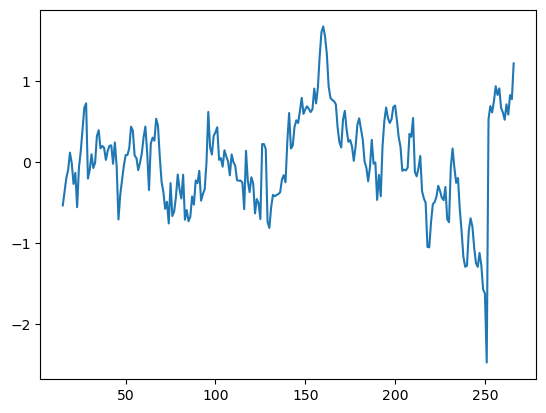

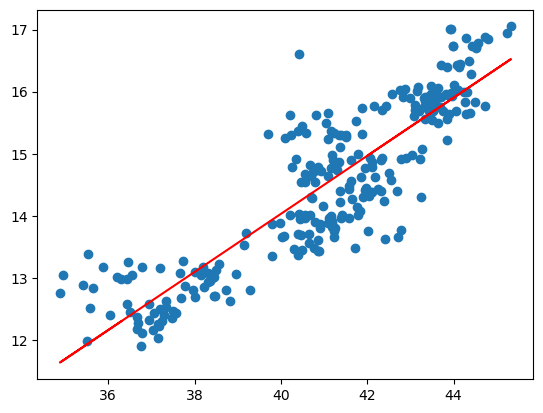

In [67]:
for n_pair in range(len(df_screaning)):

    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2][0])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4][0])

    # Residual
    pair1 = df_screaning.iloc[n_pair,0].split('/')[0]
    pair2 = df_screaning.iloc[n_pair,0].split('/')[1]
    plt.plot(df_pairs_res[pair1+'/'+pair2])
    plt.show()

    # Regression
    df_aux = df_stocks[[pair1, pair2]]
    X = df_aux.iloc[:, 0].values.reshape(-1, 1)
    Y = df_aux.iloc[:, 1].values.reshape(-1, 1)
        
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()

